In [293]:
import pandas as pd
import sys
import numpy as np
import os
import json
import re
import torch
import ast
import cv2
import io
from PIL import Image, ImageDraw
from torch import Tensor
import torchvision
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FasterRCNN

import math
from math import sqrt

In [294]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [295]:
from RPN_custom import RPN_custom

In [296]:
torch.__version__

'1.7.0+cu101'

In [297]:
"'1.7.0+cu101'"
#Cuda compilation tools, release 10.1, V10.1.105

"'1.7.0+cu101'"

In [298]:
from torchvision.transforms import functional as F

def collate_fn(batch):
    return tuple(zip(*batch))



def resize_bbox(image_shape, newsize, bbox):
    x1, y1, w, h = bbox
    w_conv = newsize[0]/image_shape[0]
    h_conv = newsize[1]/image_shape[1]
    (x1, y1, w, h) = (x1*w_conv, y1*h_conv, w*w_conv, h*h_conv)
    return x1, y1, w, h




def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    b1x1,b1y1,b1x2,b1y2 = bb1[0],bb1[1],bb1[2],bb1[3]
    b2x1,b2y1,b2x2,b2y2 = bb2[0],bb2[1],bb2[2],bb2[3]
    
    
    assert b1x1 < b1x2
    assert b1y1 < b1y2
    assert b2x1 < b2x2
    assert b2y1 < b2y2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1x1, b2x1)
    y_top = max(b1y1, b2y1)
    x_right = min(b1x2, b2x2)
    y_bottom = min(b1y2, b2y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (b1x2 - b1x1) * (b1y2 - b1y1)
    bb2_area = (b2x2 - b2x1) * (b2y2 - b2y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [299]:
min_size = 550  
max_size = 700  

image_means = [0.9492,0.9492,0.9492]
image_stds = [0.1158,0.1158,0.1158]

In [300]:
num_classes = 2

model_name = 'resnet152'
backbone = resnet_fpn_backbone('resnet152', True)
model = FasterRCNN(backbone, num_classes, min_size=min_size, max_size=max_size, image_mean = image_means, image_std = image_stds)
#model = RPN_custom(backbone, num_classes, min_size=min_size, max_size=max_size, image_mean = image_means , image_std = image_stds)
model.load_state_dict(torch.load(r"C:\Users\Jesper\Desktop\Jakob_Detection_Training\resnet152\model.pt"))



model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.9492, 0.9492, 0.9492], std=[0.1158, 0.1158, 0.1158])
      Resize(min_size=(550,), max_size=700, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsa

In [316]:
Annotations_train = pd.read_csv('Detection/annotations/Annotations_train_sample.csv')
Annotations_temp = pd.read_csv('Detection/annotations/Annotations.csv')

In [317]:
#Annotations_temp = Annotations_temp[Annotations_temp['Type']!='tablebank_word_train']

In [318]:
 Annotations_temp.join(Annotations_train.set_index('filename'),on='filename',how='outer',rsuffix='rr')

,filename,BoundingBoxes,Type,BoundingBoxesrr,Typerr
0,1401.0094_2.jpg,"[[85, 445, 443, 85]]",tablebank_latex_val,NaN,NaN
1,1401.0190_18.jpg,"[[146, 330, 311, 77], [149, 417, 305, 77]]",tablebank_latex_val,NaN,NaN
2,1401.0385_5.jpg,"[[154, 52, 45, 67]]",tablebank_latex_val,NaN,NaN
3,1401.0652_7.jpg,"[[77, 117, 440, 223]]",tablebank_latex_val,NaN,NaN
4,1401.0817_13.jpg,"[[214, 522, 183, 87]]",tablebank_latex_val,NaN,NaN
...,...,...,...,...,...
67434,105cchmava_10.jpg,"[[125, 248, 390, 83]]",tablebank_word_train,NaN,NaN
67435,12360645_5.jpg,"[[66, 101, 736, 400]]",tablebank_word_train,"[[66, 101, 736, 400]]",tablebank_word_train
67436,1482851465062-000A10458-Argentina-P115183-ABP-...,"[[67, 86, 461, 108]]",tablebank_word_train,NaN,NaN
67437,1-definiciones-basicas-en-proyectos-de-inversi...,"[[90, 106, 427, 140], [90, 273, 427, 61]]",tablebank_word_test,NaN,NaN


In [319]:
#Create test data
testdf = Annotations_temp.join(Annotations_train.set_index('filename'),on='filename',how='outer',rsuffix='rr')

testdf = testdf[testdf['Typerr'].isna()]
testdf = testdf[['filename','BoundingBoxes']].sample(n=10000,random_state=420, axis=0)

In [320]:
testdf.head()

,filename,BoundingBoxes
22704,1407.7739_16.jpg,"[[72, 418, 469, 232]]"
58989,1507.00459_7.jpg,"[[260, 146, 95, 92]]"
57782,1506.06700_4.jpg,"[[51, 93, 503, 393]]"
45419,1503.01331_2.jpg,"[[350, 114, 174, 263]]"
51940,1504.08349_31.jpg,"[[80, 68, 450, 105]]"


In [306]:
class TableBank():
    def __init__(self,images_path, df, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
       
        self.annotations = df
        self.images_path = images_path
        #self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.images_path,
                                self.annotations.iloc[idx]['filename'])
        
        image = Image.open(img_path).convert("RGB")
        image_shape = image.size
        newsize = (550,700)
        image = image.resize(newsize,resample=Image.BILINEAR)
        bboxes = ast.literal_eval(self.annotations.iloc[idx]['BoundingBoxes'])

        #boxes = np.zeros((1,4), dtype=np.float32)
        areas = []
        boxes = []
        for i in range(len(bboxes)):
            (x1, y1, w, h) = resize_bbox(image_shape, newsize, bboxes[i])
            x2 = x1+w
            y2 = y1+h
            boxes.append([x1,y1,x2,y2])
            areas.append((h*w))
            #if area < h*w:
            #    area = h*w
            #    boxes[0,:] = [x1,y1,x2,y2]

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((len(boxes)), dtype=torch.int64)
        #labels = torch.ones(1, dtype = torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.int64)
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = areas
        target["iscrowd"] = iscrowd        

        image = F.to_tensor(image)

        return image, target,self.annotations.iloc[idx]['filename']

In [307]:
images_path = 'Detection/images/'
TBtest = TableBank(images_path, testdf)

In [308]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [309]:
dataloader = torch.utils.data.DataLoader(TBtest, batch_size=8,
                                sampler=None, num_workers=0, collate_fn=collate_fn)

# Get predictions on test set

In [310]:
testdf['predictions'] = None
testdf['scores'] = None
testdf = testdf.set_index('filename')

In [311]:
testdf

,BoundingBoxes,predictions,scores
filename,,,
1407.7739_16.jpg,"[[72, 418, 469, 232]]",None,None
1507.00459_7.jpg,"[[260, 146, 95, 92]]",None,None
1506.06700_4.jpg,"[[51, 93, 503, 393]]",None,None
1503.01331_2.jpg,"[[350, 114, 174, 263]]",None,None
1504.08349_31.jpg,"[[80, 68, 450, 105]]",None,None
...,...,...,...
1503.01742_7.jpg,"[[72, 95, 469, 142]]",None,None
1409.4554_1.jpg,"[[54, 624, 247, 96]]",None,None
1410.1024_5.jpg,"[[75, 629, 199, 90]]",None,None


# Ikke kør nedenstående , kommer til at tage max lang tid.
Se istedet nedenfor hvordan du indlæser testdf fra pickle

In [312]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.9492, 0.9492, 0.9492], std=[0.1158, 0.1158, 0.1158])
      Resize(min_size=(550,), max_size=700, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsa

In [313]:
from time import time

t = time()  
   
model.to(device)
model.eval()
    
for ct, obj in enumerate(dataloader):
    img = obj[0]
    annotations = obj[1]
    filename = obj[2]
    with(torch.no_grad()):
        #Get predictions 
        images = list(image.to(device) for image in img)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(images)
        
    #input predictions in df for later calculations
    count = 0
    for pred,idx in zip(predictions,filename):
        #only keep predictions with confidence over 0.9
        
        #temp_boxes = []
        #temp_scores = []
        #for box,score in zip(pred['boxes'].cpu().numpy(),pred['scores'].cpu().numpy()):
        #    if score >= 0.9:
        #        temp_boxes.append(box)
        #        temp_scores.append(score)
        
        
        #testdf.loc[idx]['predictions'] = temp_boxes
        #testdf.loc[idx]['scores'] = temp_scores
        
        testdf.loc[idx]['BoundingBoxes'] = obj[1][count]['boxes'].numpy()
        testdf.loc[idx]['predictions'] = pred['boxes'].cpu().numpy()
        testdf.loc[idx]['scores'] = pred['scores'].cpu().numpy()
        
        count+=1 
    #print(ct)
    if ct % 20 == 0:
        tottime = (time()-t)/20
        print(f"Counter: {ct}/1250. Average time per loop iteration: {tottime:.5f} sec.")
        t = time()
        
testdf = testdf.reset_index()

Counter: 0/1250. Average time per loop iteration: 0.04990 sec.
Counter: 20/1250. Average time per loop iteration: 0.77231 sec.
Counter: 40/1250. Average time per loop iteration: 0.79940 sec.
Counter: 60/1250. Average time per loop iteration: 0.82559 sec.
Counter: 80/1250. Average time per loop iteration: 0.82702 sec.
Counter: 100/1250. Average time per loop iteration: 0.82373 sec.
Counter: 120/1250. Average time per loop iteration: 0.80630 sec.
Counter: 140/1250. Average time per loop iteration: 0.81113 sec.
Counter: 160/1250. Average time per loop iteration: 0.80485 sec.
Counter: 180/1250. Average time per loop iteration: 0.82019 sec.
Counter: 200/1250. Average time per loop iteration: 0.82071 sec.
Counter: 220/1250. Average time per loop iteration: 0.84136 sec.
Counter: 240/1250. Average time per loop iteration: 0.83738 sec.
Counter: 260/1250. Average time per loop iteration: 0.81655 sec.
Counter: 280/1250. Average time per loop iteration: 0.87361 sec.
Counter: 300/1250. Average time

## Nedenstående gælder kun for RPN

In [120]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_df(row):
    v = []
    x = row['scores']
    for i in x:
        v.append(sigmoid(i)) 
    return np.array(v)

In [121]:
#only for RPN
testdf['scores'] = testdf.apply(lambda row: sigmoid_df(row), axis=1)

In [31]:
testdf.to_csv('RPNresnet50/testscores.csv')

In [36]:
def nms(boxes: Tensor, scores: Tensor, iou_threshold: float) -> Tensor:
    return torch.ops.torchvision.nms(boxes, scores, iou_threshold)

In [129]:
#apply nms on predictions and scores

def filter_predictions(RPNdf_row,iou_threshold):
    bboxes = torch.from_numpy(RPNdf_row['predictions']).type(torch.DoubleTensor)
    scores = torch.from_numpy(RPNdf_row['scores']).type(torch.DoubleTensor)
    _slice = nms(bboxes, scores,iou_threshold)
    return [RPNdf_row['predictions'][_slice],RPNdf_row['scores'][_slice]]

def scores(row):
    return row['predictions_scores'][1]

def predictions(row):
    return row['predictions_scores'][0]



In [123]:
testdf['predictions_scores'] = testdf.apply(lambda row: filter_predictions(row, 0.1), axis=1)

In [130]:
testdf['predictions'] = testdf.apply(lambda row: predictions(row), axis=1)
testdf['scores'] = testdf.apply(lambda row: scores(row), axis=1)

In [163]:
testdf = testdf[['filename','BoundingBoxes','predictions', 'scores']]

In [144]:
get_iou(testdf.iloc[0]['predictions'][0], testdf.iloc[0]['predictions'][1])

0.2584308488353808

## Visualisering

In [51]:
from PIL import Image

In [117]:
index = idxs[0]
nr = 1
bb = 0

In [118]:
GTboxes = testdf.iloc[index]['BoundingBoxes']
numGT = len(GTboxes)

In [119]:
bboxes = testdf.iloc[index]['predictions']
scores = testdf.iloc[index]['scores']
(x1_, y1_, x2_, y2_) = bboxes[nr]

(x1, y1, x2, y2) = testdf.iloc[index]['BoundingBoxes'][bb]

In [120]:
print('ground truth: ',x1, y1, x2, y2)
print('predicted: ', x1_, y1_, x2_, y2_)
print('IoU: ', get_iou([x1, y1, x2, y2], [x1_, y1_, x2_, y2_]))
print('score: ', testdf.iloc[index]['scores'][nr])

ground truth:  64.70588 24.747475 496.9771 500.25253
predicted:  44.48094 60.462875 480.43445 107.22476
IoU:  0.09414487579327017
score:  0.9967589


In [239]:
def visualizeimg(index, thresh):
    img_path = os.path.join(images_path,
                                testdf.iloc[index]['filename'])
    image = Image.open(img_path).convert("RGB")
    image_shape = image.size
    newsize = (550,700)
    image = image.resize(newsize)
    draw = ImageDraw.Draw(image)
    
    bboxes = testdf.iloc[index]['predictions']
    scores = testdf.iloc[index]['scores']
    GTboxes = testdf.iloc[index]['BoundingBoxes']
    numGT = len(GTboxes)


    for i in range(len(bboxes)):
        #prediction coordinates (green)
        if scores[i] >= thresh:
            x1_, y1_, x2_, y2_ = bboxes[i]
            draw.rectangle([x1_, y1_, x2_, y2_], outline=(0, 255, 0, 0), width=2)

    for j in range(numGT):
        #GTboxes (red)
        (x1, y1, x2, y2) = GTboxes[j]
        draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0, 0), width=2)


    savepath = 'predicted images/{}_{}'.format(model_name,testdf.iloc[index]['filename'])
    image.save(savepath)
    return savepath

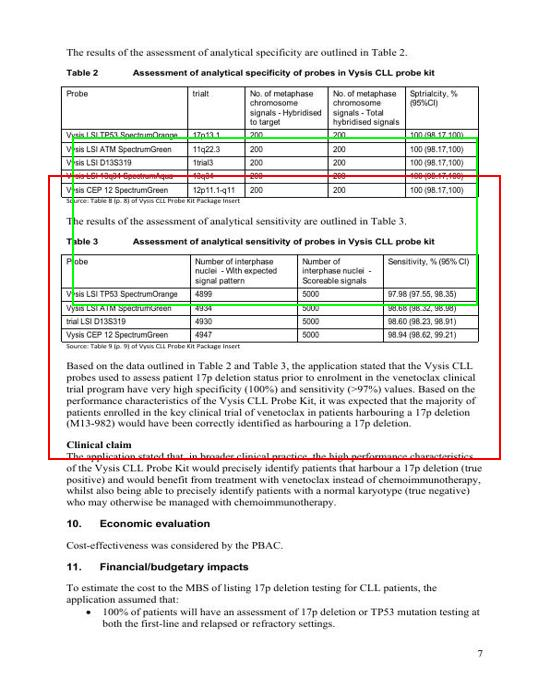

In [225]:
index = 9978
Image.open(visualizeimg(index,0.49)).convert('RGB')

In [94]:
def keep(row, min_iou, max_iou ):
    preds = row['predictions']
    scores = row['scores']
    targets = row['BoundingBoxes']
    val = []
    for i in range(len(preds)):
        if scores[i] >= 0.95:
            _iou = 0
            for tgt in targets:
                iou = get_iou(tgt, preds[i])
                if iou > _iou:
                    _iou = iou
            if _iou >= min_iou and _iou < max_iou:
                val.append(i)
    return np.array(val)
            
    
    

In [143]:
def keep2(row, max_iou):
    preds = row['predictions']
    scores = row['scores']
    targets = row['BoundingBoxes']
    val = []
    for idx,tgt in enumerate(targets):
        _iou = 0
        for i in range(len(preds)):
                iou = get_iou(tgt, preds[i])
                if iou > _iou:
                    _iou = iou
        if _iou < max_iou:
            val.append(idx)
    return np.array(val)

In [147]:
testdf['FN'] = testdf.apply(lambda row: keep2(row, 0.5), axis=1)
idxs = []
for row in testdf.iterrows():
    if len(row[1]['FN']) > 0:
        idxs.append(row[0])


In [146]:
testdf['FP'] = testdf.apply(lambda row: keep(row, 0, 0.5), axis=1)
idxs = []
for row in testdf.iterrows():
    if len(row[1]['FP']) > 0:
        idxs.append(row[0])
    

In [136]:
testdf['0.8-0.9'] = testdf.apply(lambda row: keep(row, 0.8, 0.9), axis=1)
idxs = []
for row in testdf.iterrows():
    if len(row[1]['0.8-0.9']) > 0:
        idxs.append(row[0])

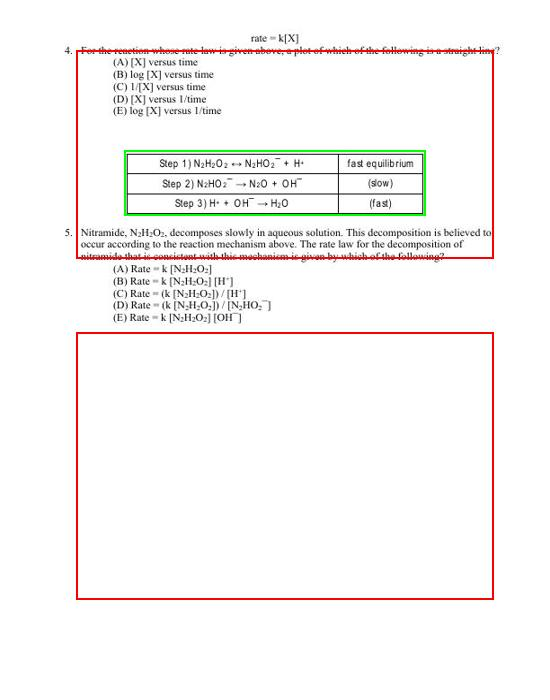

In [247]:
index = idxs[6]
Image.open(visualizeimg(index,0.431)).convert('RGB')

# Statistics

In [284]:
import pickle

with open('resnet152/losses val dict resnet152.pickle', 'rb') as handle:
    Ls_val = pickle.load(handle)


with open('resnet152/losses train dict resnet152.pickle', 'rb') as handle:
    Ls = pickle.load(handle)

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 20
epoch = np.arange(num_epochs)+1
plt.figure()
plt.plot(epoch, L_val_rn50['total loss'], 'r', epoch, L_val_rn18['total loss'], 'b')
plt.legend(['Resnet50','Resnet18'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xticks(np.arange(0, 21, step=1))
plt.grid()
plt.savefig('Validationlosses')

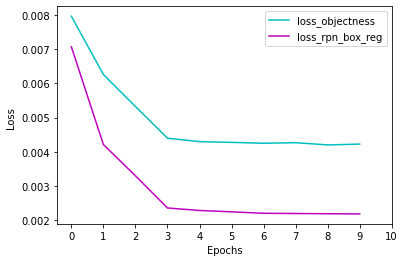

In [289]:
import matplotlib.pyplot as plt
epoch = np.arange(10)
plt.figure()
plt.plot(epoch, Ls_val['loss_objectness'], 'c', epoch, Ls_val['loss_rpn_box_reg'], 'm')
plt.legend(['loss_objectness', 'loss_rpn_box_reg'])
plt.xticks(np.arange(0, 11, step=1))
plt.xlabel('Epochs')
plt.ylabel('Loss  ')
plt.savefig('resnet152/Final losses {}.png'.format(model_name))

In [21]:
def TP_FP(preds,scores,targets,IoU_thresh,pred_thresh):
    #Beregner TP, FP og FN baseret på targets og predictions
    
    #Bliver kaldt elementvist på hver række fra dataframe
    
    
    TP = 0
    FP = 0
    FN = 0
    selected = np.zeros(len(targets))
    for pred,score in zip(preds,scores):
        
        max_iou = 0
        target_loc = None
        if score >= pred_thresh:
            #Iterate over all targets to identify largest IoU
            for i,tgt in enumerate(targets):
                iou = get_iou(pred,tgt)
                if iou >= max_iou:
                    max_iou = iou
                    target_loc = i
                  
            #If targets IoU is over threshold, then prediction is correctly classified
            if max_iou >= IoU_thresh:
                
                #Test if target has already been "selected" by other prediction
                if selected[target_loc] != 1:
                    selected[target_loc] = 1
                    TP+=1
                else:
                    #If target have already been assigned a positive prediction, then the following predictions on this target 
                    #are classified as false positives
                    FP+=1
                    
            #If not IoU over threshold, then prediction is false positive
            else:
                FP+=1
            
    
    #False negatives are targets that have not been predicted
    FN = len(targets)-TP
    if FN < 0:
        print(TP,FP,FN)
    
    return TP,FP,FN
        

#######VIGTIG#########    
TP_FP_vec = np.vectorize(TP_FP)  

#Vectorisering af funktionen gør at vi kan kalde funktionen på alle elementer i hver række i df. 
######################
    
def precision_recall(targets_series,preds_series,scores_series,IoU,pred_thresh):
    
    TP_ar,FP_ar,FN_ar = TP_FP_vec(preds_series,scores_series,targets_series,IoU,pred_thresh)
    
    TP = sum(TP_ar)
    FP = sum(FP_ar)
    FN = sum(FN_ar)
    
    
    return TP/(TP+FP),TP/(TP+FN)
      
def precision_recall_curve(df,IoU):
    
    targets_series = df['BoundingBoxes']
    preds_series = df['predictions']
    scores_series = df['scores']
    
    precisions = []
    recalls = []
    F1 = []
    for thresh in np.arange(0.5,1.0,0.05):
        prec, rec = precision_recall(targets_series,preds_series,scores_series,IoU,thresh)
        precisions.append(prec)
        recalls.append(rec)
        F1.append(2*(prec*rec)/(prec+rec))
    
    return precisions,recalls, F1

In [314]:
precisions,recalls, F1 = precision_recall_curve(testdf,0.5)

for i in range(len(precisions)):
    #the threshold denotes what the score of a prediction should be above to be included as a prediction
    print('thresh = ', round(0.5+i*0.05,3))
    print('precision = ',round(precisions[i],3))
    print('recall = ',round(recalls[i],3))
    print('F1 = ',round(F1[i],3))
    print('------------------')

thresh =  0.5
precision =  0.926
recall =  0.936
F1 =  0.931
------------------
thresh =  0.55
precision =  0.934
recall =  0.934
F1 =  0.934
------------------
thresh =  0.6
precision =  0.94
recall =  0.933
F1 =  0.937
------------------
thresh =  0.65
precision =  0.944
recall =  0.933
F1 =  0.938
------------------
thresh =  0.7
precision =  0.948
recall =  0.932
F1 =  0.94
------------------
thresh =  0.75
precision =  0.951
recall =  0.931
F1 =  0.941
------------------
thresh =  0.8
precision =  0.954
recall =  0.93
F1 =  0.942
------------------
thresh =  0.85
precision =  0.959
recall =  0.93
F1 =  0.944
------------------
thresh =  0.9
precision =  0.964
recall =  0.928
F1 =  0.946
------------------
thresh =  0.95
precision =  0.969
recall =  0.926
F1 =  0.947
------------------
